<a href="https://colab.research.google.com/github/elmidion/Ablation_result_prediction/blob/main/Ablation_result_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import auth
auth.authenticate_user()

from google.colab import drive

drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns

import tensorflow as tf
import numpy as np
print(tf.__version__)
tf.random.set_seed(20200819)

import os
from time import time

2.3.0


In [3]:
os.chdir('/content/gdrive/My Drive/AI/Dose prediction/')

In [4]:
Dose = pd.read_csv('Dose prediction_20200819.csv')

Dose.head()

,ID,age,sex,HTN,DM,TB,Hepatitis,OtherthyroidD,Op,biopsy,tumorsize,pT,pN,pM,cT,preadmissiondate,preTg,preATA,preTSH,dose,preparation,FUdate,FUscan,Furesult,Fubinary
0,16,29,1,0,0,0,0,0,TT,1,4.0,2,1b,0,2,2000-12-28,55.6,128.0,1.00,350,1,2002-01-16,1,Biochemical incomplete,0
1,19,26,2,0,0,0,0,0,TT RND,1,2.0,1b,1a,0,1b,2001-08-13,11.0,2.0,69.80,200,1,2002-03-06,1,Biochemical incomplete,0
2,20,54,2,0,0,0,0,0,TT,1,2.0,2,1a,0,4a,2001-09-03,29.0,2.0,61.20,300,1,2002-04-03,2,Structural incomplete,0
3,22,41,1,0,0,0,0,0,TT,1,1.5,3a,1a,0,3a,2001-10-08,16.0,2.0,59.89,150,1,2002-05-08,1,Biochemical incomplete,0
4,23,62,2,0,0,0,1,0,TT,1,3.0,2,1a,0,3b,2001-10-08,22.0,2.0,58.46,200,1,2002-08-07,1,Biochemical incomplete,0


In [5]:
# THW 환자만 대상
THW = Dose['preparation']==1
Dose_main = Dose[THW]

In [6]:
Dose_main.columns
Dose_main = Dose_main.drop(['ID', 'preadmissiondate', 'preparation', 'FUdate', 'FUscan', 'Furesult'], axis='columns')
#Dose_main.head
#Dose_main.describe()

Dose_main.pN[Dose_main.pN==' 1b'] = '1b'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [7]:
Dose_main.head()

,age,sex,HTN,DM,TB,Hepatitis,OtherthyroidD,Op,biopsy,tumorsize,pT,pN,pM,cT,preTg,preATA,preTSH,dose,Fubinary
0,29,1,0,0,0,0,0,TT,1,4.0,2,1b,0,2,55.6,128.0,1.00,350,0
1,26,2,0,0,0,0,0,TT RND,1,2.0,1b,1a,0,1b,11.0,2.0,69.80,200,0
2,54,2,0,0,0,0,0,TT,1,2.0,2,1a,0,4a,29.0,2.0,61.20,300,0
3,41,1,0,0,0,0,0,TT,1,1.5,3a,1a,0,3a,16.0,2.0,59.89,150,0
4,62,2,0,0,0,1,0,TT,1,3.0,2,1a,0,3b,22.0,2.0,58.46,200,0


In [8]:
Dose_main.Fubinary.value_counts()

0    327
1    304
Name: Fubinary, dtype: int64

In [9]:
from scipy import stats

def base_stat(*features):
  for feature in features:
    print(pd.DataFrame(feature))
    print('Min : ', np.min(feature))  
    print('Median : ', np.median(feature))
    print('Max : ', np.max(feature))
    
    print('Mean : ', np.mean(feature))
    print('std : ', np.std(feature))
  if len(features) == 2:
    print('Compare the mean between two groups')
    
    print('\n')
    feature1 = features[0]
    feature2 = features[1]
    levene, levene_p = stats.levene(feature1, feature2)
    print('등분산 여부 : levene', levene, 'p-value :', levene_p)
    
    print('\n')
    if levene_p < 0.05:
      t, p = stats.ttest_ind(feature1, feature2, equal_var=False) 
      print('T값 : ', t, 'p-value :',p)
    else:
      t, p = stats.ttest_ind(feature1, feature2, equal_var=True) 
      print('T값 : ', t, 'p-value :',p)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


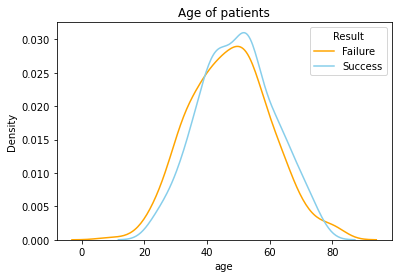

     age
0     29
1     26
2     54
3     41
4     62
..   ...
741   28
754   25
769   81
773   38
774   43

[327 rows x 1 columns]
Min :  9
Median :  48.0
Max :  82
Mean :  47.345565749235476
std :  12.782101289105128
     age
12    50
27    25
41    61
44    31
47    70
..   ...
714   50
729   35
734   70
747   43
759   24

[304 rows x 1 columns]
Min :  23
Median :  50.0
Max :  76
Mean :  49.56578947368421
std :  11.740153238392663
Compare the mean between two groups


등분산 여부 : levene 1.5130601057000719 p-value : 0.21913258652366646


T값 :  -2.2636585484167218 p-value : 0.02393497177233088


In [10]:
#(ax.set_title(), ax.set_xlabel(), ax.set_ylabel())

sns.distplot(Dose_main[Dose_main['Fubinary'] == 0]['age'], hist=False, color="orange", label="Failure")
sns.distplot(Dose_main[Dose_main['Fubinary'] == 1]['age'], hist=False, color="skyblue", label="Success")
plt.title('Age of patients')
plt.legend(title="Result")
plt.show()

base_stat(Dose_main[Dose_main['Fubinary'] == 0]['age'], Dose_main[Dose_main['Fubinary'] == 1]['age'])

In [11]:
def Xtab(index, columns):
  Xtab = pd.crosstab(index=index, columns=columns, margins=True)
  print(Xtab)
  c, p, dof, expected = stats.chi2_contingency(Xtab)
  print('카이제곱값: ', c, 'P-values :', p, '\n')
  print(pd.crosstab(index=index, columns=columns, margins=True, normalize=True))

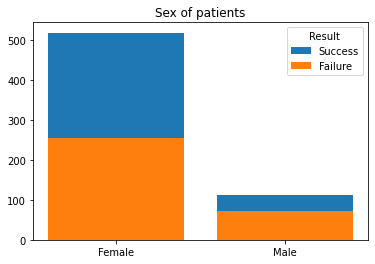

Fubinary    0    1  All
sex                    
1          73   40  113
2         254  264  518
All       327  304  631
카이제곱값:  9.003829073967477 P-values : 0.06100384355570909 

Fubinary         0         1       All
sex                                   
1         0.115689  0.063391  0.179081
2         0.402536  0.418384  0.820919
All       0.518225  0.481775  1.000000


In [12]:
x = ['Female', 'Male']
y = Dose_main['sex'].value_counts()

a = ['Female', 'Male']
b = Dose_main[Dose_main['Fubinary'] == 0]['sex'].value_counts()
plt.bar(x, y, label='Success')
plt.bar(a, b, label='Failure')

plt.title('Sex of patients')
plt.legend(title="Result")
plt.show()

Xtab(Dose_main['sex'], Dose_main['Fubinary'])

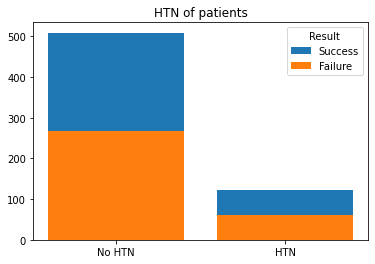

Fubinary    0    1  All
HTN                    
0         267  242  509
1          60   62  122
All       327  304  631
카이제곱값:  0.42289476312414076 P-values : 0.9805598904204162 

Fubinary         0         1       All
HTN                                   
0         0.423138  0.383518  0.806656
1         0.095087  0.098257  0.193344
All       0.518225  0.481775  1.000000


In [13]:
x = [0, 1]
y = Dose_main['HTN'].value_counts()

a = [0, 1]
b = Dose_main[Dose_main['Fubinary'] == 0]['HTN'].value_counts()
plt.bar(x, y, label='Success')
plt.bar(a, b, label='Failure')

plt.title('HTN of patients')
plt.legend(title="Result")
plt.xticks([0,1],['No HTN', 'HTN'])
plt.show()

Xtab(index=Dose_main['HTN'], columns=Dose_main['Fubinary'])

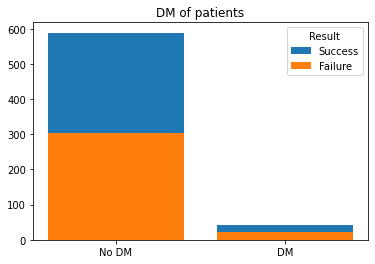

Fubinary    0    1  All
DM                     
0         304  285  589
1          23   19   42
All       327  304  631
카이제곱값:  0.15571066273012116 P-values : 0.9971220803293211 

Fubinary         0         1       All
DM                                    
0         0.481775  0.451664  0.933439
1         0.036450  0.030111  0.066561
All       0.518225  0.481775  1.000000


In [14]:
x = [0, 1]
y = Dose_main['DM'].value_counts()

a = [0, 1]
b = Dose_main[Dose_main['Fubinary'] == 0]['DM'].value_counts()
plt.bar(x, y, label='Success')
plt.bar(a, b, label='Failure')

plt.title('DM of patients')
plt.legend(title="Result")
plt.xticks([0,1],['No DM', 'DM'])
plt.show()

Xtab(index=Dose_main['DM'], columns=Dose_main['Fubinary'])

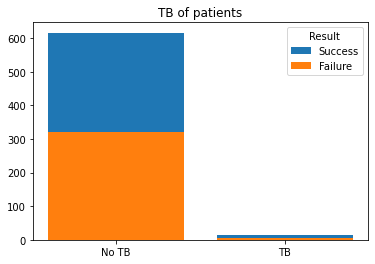

Fubinary    0    1  All
TB                     
0         321  295  616
1           6    9   15
All       327  304  631
카이제곱값:  0.8601936352819076 P-values : 0.9302009219916003 

Fubinary         0         1       All
TB                                    
0         0.508716  0.467512  0.976228
1         0.009509  0.014263  0.023772
All       0.518225  0.481775  1.000000


In [15]:
x = [0, 1]
y = Dose_main['TB'].value_counts()

a = [0, 1]
b = Dose_main[Dose_main['Fubinary'] == 0]['TB'].value_counts()
plt.bar(x, y, label='Success')
plt.bar(a, b, label='Failure')

plt.title('TB of patients')
plt.legend(title="Result")
plt.xticks([0,1],['No TB', 'TB'])
plt.show()

Xtab(index=Dose_main['TB'], columns=Dose_main['Fubinary'])

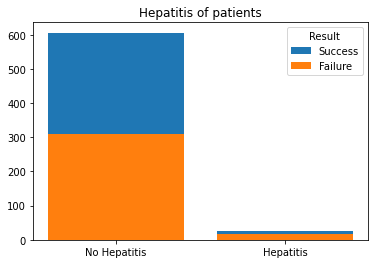

Fubinary     0    1  All
Hepatitis               
0          311  295  606
1           16    9   25
All        327  304  631
카이제곱값:  1.5461446422889518 P-values : 0.8184372869308019 

Fubinary          0         1      All
Hepatitis                             
0          0.492868  0.467512  0.96038
1          0.025357  0.014263  0.03962
All        0.518225  0.481775  1.00000


In [16]:
x = [0, 1]
y = Dose_main['Hepatitis'].value_counts()

a = [0, 1]
b = Dose_main[Dose_main['Fubinary'] == 0]['Hepatitis'].value_counts()
plt.bar(x, y, label='Success')
plt.bar(a, b, label='Failure')

plt.title('Hepatitis of patients')
plt.legend(title="Result")
plt.xticks([0,1],['No Hepatitis', 'Hepatitis'])
plt.show()

Xtab(index=Dose_main['Hepatitis'], columns=Dose_main['Fubinary'])

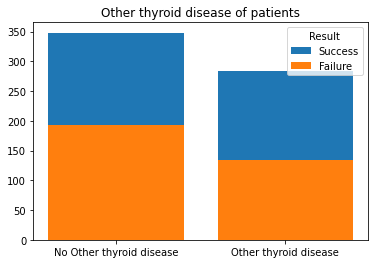

Fubinary         0    1  All
OtherthyroidD               
0              193  155  348
1              134  149  283
All            327  304  631
카이제곱값:  4.111589159773389 P-values : 0.391114497467873 

Fubinary              0         1       All
OtherthyroidD                              
0              0.305864  0.245642  0.551506
1              0.212361  0.236133  0.448494
All            0.518225  0.481775  1.000000


In [17]:
x = [0, 1]
y = Dose_main['OtherthyroidD'].value_counts()

a = [0, 1]
b = Dose_main[Dose_main['Fubinary'] == 0]['OtherthyroidD'].value_counts()
plt.bar(x, y, label='Success')
plt.bar(a, b, label='Failure')

plt.title('Other thyroid disease of patients')
plt.legend(title="Result")
plt.xticks([0,1],['No Other thyroid disease', 'Other thyroid disease'])
plt.show()

Xtab(index=Dose_main['OtherthyroidD'], columns=Dose_main['Fubinary'])

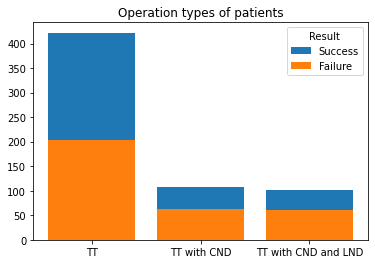

Fubinary    0    1  All
Op                     
TT         61   46  107
TT CND    204  218  422
TT RND     62   40  102
All       327  304  631
카이제곱값:  6.482617790983625 P-values : 0.37134937413335894 

Fubinary         0         1       All
Op                                    
TT        0.096672  0.072900  0.169572
TT CND    0.323296  0.345483  0.668780
TT RND    0.098257  0.063391  0.161648
All       0.518225  0.481775  1.000000


In [18]:
x = [0, 1, 2]
y = Dose_main['Op'].value_counts()

a = [0, 1, 2]
b = Dose_main[Dose_main['Fubinary'] == 0]['Op'].value_counts()
plt.bar(x, y, label='Success')
plt.bar(a, b, label='Failure')

plt.title('Operation types of patients')
plt.legend(title="Result")
plt.xticks([0,1,2],['TT', 'TT with CND', 'TT with CND and LND'])
plt.show()

Xtab(index=Dose_main['Op'], columns=Dose_main['Fubinary'])

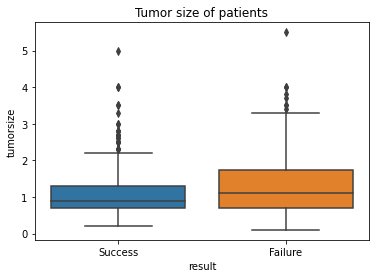

     tumorsize
0          4.0
1          2.0
2          2.0
3          1.5
4          3.0
..         ...
741        0.5
754        1.3
769        2.7
773        2.0
774        1.2

[327 rows x 1 columns]
Min :  0.1
Median :  1.1
Max :  5.5
Mean :  1.3142507645259947
std :  0.818629031145349
     tumorsize
12         1.2
27         1.0
41         2.0
44         1.5
47         1.5
..         ...
714        0.9
729        2.7
734        1.2
747        0.7
759        0.7

[304 rows x 1 columns]
Min :  0.2
Median :  0.9
Max :  5.0
Mean :  1.115953947368422
std :  0.7020297718122318
Compare the mean between two groups


등분산 여부 : levene 10.080950543456124 p-value : 0.001571292509017688


T값 :  3.267832110954589 p-value : 0.0011431341525635083


In [19]:
# x = [0, 1, 2]
# y = Dose_main['Op'].value_counts()

# a = [0, 1, 2]
# b = Dose_main[Dose_main['Fubinary'] == 0]['Op'].value_counts()
sns.boxplot(x=(1-Dose_main['Fubinary']), y=Dose_main['tumorsize'])

# plt.boxplot(x, y, label='Success')
# plt.bar(a, b, label='Failure')

plt.title('Tumor size of patients')
# plt.legend(title="Result")
plt.xticks([0,1],['Success', 'Failure'])
plt.xlabel('result')
plt.show()

base_stat(Dose_main[Dose_main['Fubinary'] == 0]['tumorsize'], Dose_main[Dose_main['Fubinary'] == 1]['tumorsize'])

In [20]:
Dose_main['cT'].value_counts().sort_index(ascending=True)

1a    283
1b    136
2      46
3a      8
3b    102
4a     56
Name: cT, dtype: int64

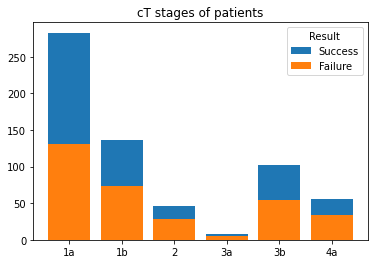

Fubinary    0    1  All
cT                     
1a        131  152  283
1b         74   62  136
2          28   18   46
3a          5    3    8
3b         55   47  102
4a         34   22   56
All       327  304  631
카이제곱값:  7.661747650473859 P-values : 0.8109737492208257 

Fubinary         0         1       All
cT                                    
1a        0.207607  0.240887  0.448494
1b        0.117274  0.098257  0.215531
2         0.044374  0.028526  0.072900
3a        0.007924  0.004754  0.012678
3b        0.087163  0.074485  0.161648
4a        0.053883  0.034865  0.088748
All       0.518225  0.481775  1.000000


In [21]:
x = ['1a', '1b', '2', '3a', '3b', '4a']
y = Dose_main['cT'].value_counts().sort_index(ascending=True)

a = ['1a', '1b', '2', '3a', '3b', '4a']
b = Dose_main[Dose_main['Fubinary'] == 0]['cT'].value_counts().sort_index(ascending=True)
plt.bar(x, y, label='Success')
plt.bar(a, b, label='Failure')

plt.title('cT stages of patients')
plt.legend(title="Result")
#plt.xticks([0,1,2],['TT', 'TT with CND', 'TT with CND and LND'])
plt.show()

Xtab(index=Dose_main['cT'], columns=Dose_main['Fubinary'])

In [22]:
Dose_main['pT'].value_counts()

1a    341
1b    209
2      67
3a     11
4a      3
Name: pT, dtype: int64

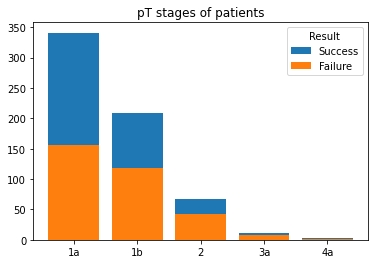

Fubinary    0    1  All
pT                     
1a        156  185  341
1b        119   90  209
2          43   24   67
3a          8    3   11
4a          1    2    3
All       327  304  631
카이제곱값:  13.664121855237983 P-values : 0.18887057547647118 

Fubinary         0         1       All
pT                                    
1a        0.247227  0.293185  0.540412
1b        0.188590  0.142631  0.331220
2         0.068146  0.038035  0.106181
3a        0.012678  0.004754  0.017433
4a        0.001585  0.003170  0.004754
All       0.518225  0.481775  1.000000


In [23]:
x = ['1a', '1b', '2', '3a', '4a']
y = Dose_main['pT'].value_counts()

a = ['1a', '1b', '2', '3a', '4a']
b = Dose_main[Dose_main['Fubinary'] == 0]['pT'].value_counts()

plt.bar(x, y, label='Success')
plt.bar(a, b, label='Failure')

plt.title('pT stages of patients')
plt.legend(title="Result")
#plt.xticks([0,1,2],['TT', 'TT with CND', 'TT with CND and LND'])
plt.show()

Xtab(index=Dose_main['pT'], columns=Dose_main['Fubinary'])

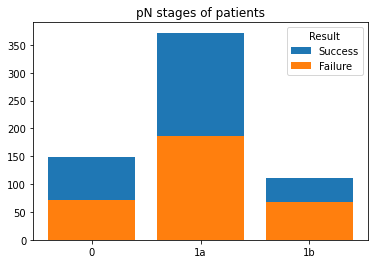

Fubinary    0    1  All
pN                     
0          72   76  148
1a        187  185  372
1b         68   43  111
All       327  304  631
카이제곱값:  4.9176732658091495 P-values : 0.5544147786267184 

Fubinary         0         1       All
pN                                    
0         0.114105  0.120444  0.234548
1a        0.296355  0.293185  0.589540
1b        0.107765  0.068146  0.175911
All       0.518225  0.481775  1.000000


In [24]:
x = ['0', '1a', '1b']
y = Dose_main['pN'].value_counts().sort_index(ascending=True)

a = ['0', '1a', '1b']
b = Dose_main[Dose_main['Fubinary'] == 0]['pN'].value_counts().sort_index(ascending=True)
plt.bar(x, y, label='Success')
plt.bar(a, b, label='Failure')

plt.title('pN stages of patients')
plt.legend(title="Result")
#plt.xticks([0,1,2],['TT', 'TT with CND', 'TT with CND and LND'])
plt.show()

Xtab(index=Dose_main['pN'], columns=Dose_main['Fubinary'])

In [25]:
Dose_main.pM.value_counts()

0    623
1      8
Name: pM, dtype: int64

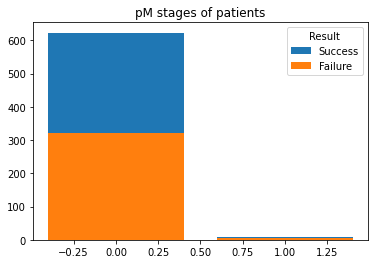

Fubinary    0    1  All
pM                     
0         322  301  623
1           5    3    8
All       327  304  631
카이제곱값:  0.37000493765790105 P-values : 0.984858196769656 

Fubinary         0         1       All
pM                                    
0         0.510301  0.477021  0.987322
1         0.007924  0.004754  0.012678
All       0.518225  0.481775  1.000000


In [26]:
x = [0, 1]
y = Dose_main['pM'].value_counts()

a = [0, 1]
b = Dose_main[Dose_main['Fubinary'] == 0]['pM'].value_counts()
plt.bar(x, y, label='Success')
plt.bar(a, b, label='Failure')

plt.title('pM stages of patients')
plt.legend(title="Result")
#plt.xticks([0,1,2],['TT', 'TT with CND', 'TT with CND and LND'])
plt.show()

Xtab(index=Dose_main['pM'], columns=Dose_main['Fubinary'])

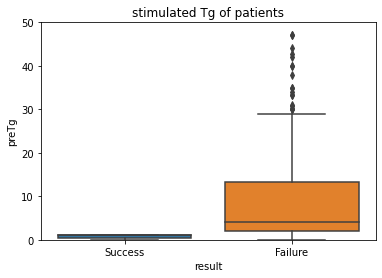

      preTg
0     55.60
1     11.00
2     29.00
3     16.00
4     22.00
..      ...
741    4.53
754  202.10
769   22.80
773   39.90
774    1.57

[327 rows x 1 columns]
Min :  0.06
Median :  4.0
Max :  375.0
Mean :  17.11874617737003
std :  38.55639706581829
     preTg
12    1.00
27    1.00
41    1.00
44    1.00
47    1.00
..     ...
714   0.02
729   0.18
734   0.18
747   0.09
759   0.10

[304 rows x 1 columns]
Min :  0.01
Median :  1.0
Max :  1.0
Mean :  0.7732861842105264
std :  0.35254328822469716
Compare the mean between two groups


등분산 여부 : levene 47.429002212618414 p-value : 1.385409410761309e-11


T값 :  7.654026669167461 p-value : 2.224492669516725e-13


In [27]:
# x = [0, 1, 2]
# y = Dose_main['Op'].value_counts()

# a = [0, 1, 2]
# b = Dose_main[Dose_main['Fubinary'] == 0]['Op'].value_counts()
sns.boxplot(x=(1-Dose_main['Fubinary']), y=Dose_main['preTg'])

# plt.boxplot(x, y, label='Success')
# plt.bar(a, b, label='Failure')

plt.title('stimulated Tg of patients')
# plt.legend(title="Result")
plt.xticks([0,1],['Success', 'Failure'])
plt.xlabel('result')
plt.ylim([0,50])
plt.show()

base_stat(Dose_main[Dose_main['Fubinary'] == 0]['preTg'], Dose_main[Dose_main['Fubinary'] == 1]['preTg'])

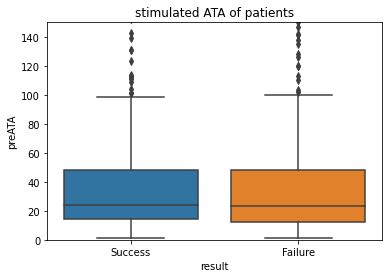

     preATA
0     128.0
1       2.0
2       2.0
3       2.0
4       2.0
..      ...
741    20.6
754    23.0
769    29.6
773    18.6
774    18.2

[327 rows x 1 columns]
Min :  1.0
Median :  23.0
Max :  1509.0
Mean :  59.71987767584094
std :  140.46520829903992
     preATA
12      1.0
27    139.0
41     53.0
44     49.0
47    291.0
..      ...
714    22.1
729    26.1
734    21.5
747    30.0
759    94.9

[304 rows x 1 columns]
Min :  1.0
Median :  24.0
Max :  2180.0
Mean :  66.27809210526314
std :  195.9058623512752
Compare the mean between two groups


등분산 여부 : levene 0.103854127857098 p-value : 0.7473597335978639


T값 :  -0.4849963252490429 p-value : 0.6278478132541939


In [28]:
# x = [0, 1, 2]
# y = Dose_main['Op'].value_counts()

# a = [0, 1, 2]
# b = Dose_main[Dose_main['Fubinary'] == 0]['Op'].value_counts()
sns.boxplot(x=(1-Dose_main['Fubinary']), y=Dose_main['preATA'])

# plt.boxplot(x, y, label='Success')
# plt.bar(a, b, label='Failure')

plt.title('stimulated ATA of patients')
# plt.legend(title="Result")
plt.xticks([0,1],['Success', 'Failure'])
plt.xlabel('result')
plt.ylim([0,150])
plt.show()

base_stat(Dose_main[Dose_main['Fubinary'] == 0]['preATA'], Dose_main[Dose_main['Fubinary'] == 1]['preATA'])

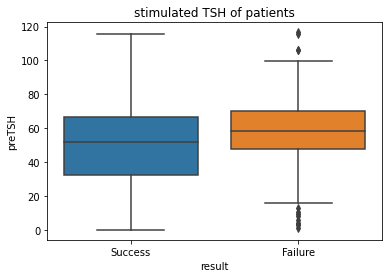

     preTSH
0      1.00
1     69.80
2     61.20
3     59.89
4     58.46
..      ...
741   70.54
754   84.45
769   59.57
773   58.95
774   41.87

[327 rows x 1 columns]
Min :  1.0
Median :  58.49
Max :  116.64
Mean :  58.68703363914374
std :  20.042206049005554
     preTSH
12    51.32
27    57.75
41    61.40
44    64.19
47    59.91
..      ...
714    0.01
729   32.50
734    0.37
747   23.77
759   68.44

[304 rows x 1 columns]
Min :  0.01
Median :  52.0
Max :  115.57
Mean :  50.03659868421052
std :  25.718070229172117
Compare the mean between two groups


등분산 여부 : levene 23.147254800508836 p-value : 1.8804161665386569e-06


T값 :  4.680988137719117 p-value : 3.5683486175293654e-06


In [29]:
# x = [0, 1, 2]
# y = Dose_main['Op'].value_counts()

# a = [0, 1, 2]
# b = Dose_main[Dose_main['Fubinary'] == 0]['Op'].value_counts()
sns.boxplot(x=(1-Dose_main['Fubinary']), y=Dose_main['preTSH'])

# plt.boxplot(x, y, label='Success')
# plt.bar(a, b, label='Failure')

plt.title('stimulated TSH of patients')
# plt.legend(title="Result")
plt.xticks([0,1],['Success', 'Failure'])
plt.xlabel('result')
plt.show()

base_stat(Dose_main[Dose_main['Fubinary'] == 0]['preTSH'], Dose_main[Dose_main['Fubinary'] == 1]['preTSH'])

In [30]:
Dose_main['dose'].value_counts().sort_index(ascending=True)

30       1
50      15
80      75
100    237
150    271
180     26
200      3
300      2
350      1
Name: dose, dtype: int64

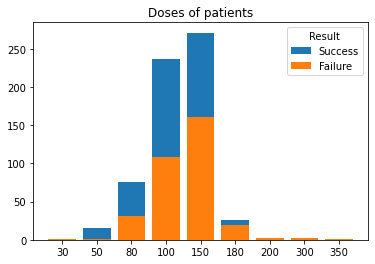

Fubinary    0    1  All
dose                   
30          1    0    1
50          1   14   15
80         31   44   75
100       108  129  237
150       161  110  271
180        19    7   26
200         3    0    3
300         2    0    2
350         1    0    1
All       327  304  631
카이제곱값:  36.72745158363891 P-values : 0.005685852137159882 

Fubinary         0         1       All
dose                                  
30        0.001585  0.000000  0.001585
50        0.001585  0.022187  0.023772
80        0.049128  0.069731  0.118859
100       0.171157  0.204437  0.375594
150       0.255151  0.174326  0.429477
180       0.030111  0.011094  0.041204
200       0.004754  0.000000  0.004754
300       0.003170  0.000000  0.003170
350       0.001585  0.000000  0.001585
All       0.518225  0.481775  1.000000


In [31]:
x = ['30', '50', '80', '100', '150', '180', '200', '300', '350']
y = Dose_main['dose'].value_counts().sort_index(ascending=True)

a = ['30', '50', '80', '100', '150', '180', '200', '300', '350']
b = Dose_main[Dose_main['Fubinary'] == 0]['dose'].value_counts().sort_index(ascending=True)
plt.bar(x, y, label='Success')
plt.bar(a, b, label='Failure')

plt.title('Doses of patients')
plt.legend(title="Result")
plt.xticks(['30', '50', '80', '100', '150', '180', '200', '300', '350'])
plt.show()

Xtab(index=Dose_main['dose'], columns=Dose_main['Fubinary'])

In [32]:
Dose_main['Fubinary'].value_counts().sort_index(ascending=True)

0    327
1    304
Name: Fubinary, dtype: int64

In [33]:
# Dose_main['Op'] = Dose_main['Op'].replace({'TT':1, 'TT CND':2, 'TT RND':3})
# Dose_main['pT'] = Dose_main['pT'].replace({'1a':1, '1b':2, '2':3, '3a':4, '4a':5})
# Dose_main['cT'] = Dose_main['cT'].replace({'1a':1, '1b':2, '2':3, '3a':4, '3b':5, '4a':6})
# Dose_main['pN'] = Dose_main['pN'].replace({'0':1, '1a':1, '1b':2})

In [34]:
## Losgistic regression

# age MinMax scaling
Dose_main['age_MM'] = (Dose_main['age'] - min(Dose_main['age']))/(max(Dose_main['age']) - min(Dose_main['age']))

# Sex Onehot encoding
Dose_main = pd.concat([Dose_main, pd.get_dummies(Dose_main.sex)], axis=1)
Dose_main.rename(columns={1:'Male'}, inplace=True)
Dose_main.rename(columns={2:'Female'}, inplace=True)

# HTN Onehot encoding
Dose_main = pd.concat([Dose_main, pd.get_dummies(Dose_main.HTN)], axis=1)
Dose_main.rename(columns={0:'NoHTN'}, inplace=True)
Dose_main.rename(columns={1:'HTN'}, inplace=True)

# DM Onehot encoding
Dose_main = pd.concat([Dose_main, pd.get_dummies(Dose_main.DM)], axis=1)
Dose_main.rename(columns={0:'NoDM'}, inplace=True)
Dose_main.rename(columns={1:'DM'}, inplace=True)

# TB Onehot encoding
Dose_main = pd.concat([Dose_main, pd.get_dummies(Dose_main.TB)], axis=1)
Dose_main.rename(columns={0:'NoTB'}, inplace=True)
Dose_main.rename(columns={1:'TB'}, inplace=True)

# Hepatitis Onehot encoding
Dose_main = pd.concat([Dose_main, pd.get_dummies(Dose_main.Hepatitis)], axis=1)
Dose_main.rename(columns={0:'NoHepatitis'}, inplace=True)
Dose_main.rename(columns={1:'Hepatitis'}, inplace=True)

# OtherthyroidD Onehot encoding
Dose_main = pd.concat([Dose_main, pd.get_dummies(Dose_main.OtherthyroidD)], axis=1)
Dose_main.rename(columns={0:'NoOtherthyroidD'}, inplace=True)
Dose_main.rename(columns={1:'OtherthyroidD'}, inplace=True)

# Op Onehot encoding
Dose_main = pd.concat([Dose_main, pd.get_dummies(Dose_main.Op)], axis=1)

'''
# Biopsy Onehot encoding
Dose_main = pd.concat([Dose_main, pd.get_dummies(Dose_main.biopsy)], axis=1)
Dose_main.rename(columns={1:'Papillary'}, inplace=True)
Dose_main.rename(columns={2:'Follicular'}, inplace=True)
'''

# Tumorsize MinMax scaling
Dose_main['tumorsize_MM'] = (np.log(Dose_main['tumorsize']) - min(np.log(Dose_main['tumorsize'])))/(max(np.log(Dose_main['tumorsize'])) - min(np.log(Dose_main['tumorsize'])))

# pT Onehot encoding
Dose_main = pd.concat([Dose_main, pd.get_dummies(Dose_main.pT)], axis=1)
Dose_main.rename(columns={'1a':'pT1a'}, inplace=True)
Dose_main.rename(columns={'1b':'pT1b'}, inplace=True)
Dose_main.rename(columns={'2':'pT2'}, inplace=True)
Dose_main.rename(columns={'3a':'pT3a'}, inplace=True)
Dose_main.rename(columns={'4a':'pT4a'}, inplace=True)

# pN Onehot encoding
Dose_main = pd.concat([Dose_main, pd.get_dummies(Dose_main.pN)], axis=1)
Dose_main.rename(columns={'0':'N0'}, inplace=True)
Dose_main.rename(columns={'1a':'N1a'}, inplace=True)
Dose_main.rename(columns={'1b':'N1b'}, inplace=True)
Dose_main.rename(columns={' 1b':'N1b'}, inplace=True)

# pM Onehot encoding
Dose_main = pd.concat([Dose_main, pd.get_dummies(Dose_main.pM)], axis=1)
Dose_main.rename(columns={0:'M0'}, inplace=True)
Dose_main.rename(columns={1:'M1'}, inplace=True)

# cT Onehot encoding
Dose_main = pd.concat([Dose_main, pd.get_dummies(Dose_main.cT)], axis=1)
Dose_main.rename(columns={'1a':'cT1a'}, inplace=True)
Dose_main.rename(columns={'1b':'cT1b'}, inplace=True)
Dose_main.rename(columns={'2':'cT2'}, inplace=True)
Dose_main.rename(columns={'3a':'cT3a'}, inplace=True)
Dose_main.rename(columns={'3b':'cT3b'}, inplace=True)
Dose_main.rename(columns={'4a':'cT4a'}, inplace=True)


# preTg MinMax scaling
Dose_main['preTg_MM'] = (np.log(Dose_main['preTg']) - min(np.log(Dose_main['preTg'])))/(max(np.log(Dose_main['preTg'])) - min(np.log(Dose_main['preTg'])))

# preATA MinMax scaling
Dose_main['preATA_MM'] = (np.log(Dose_main['preATA']) - min(np.log(Dose_main['preATA'])))/(max(np.log(Dose_main['preATA']) )- min(np.log(Dose_main['preATA'])))

# preTSH MinMax scaling
Dose_main['preTSH_MM'] = (Dose_main['preTSH'] - min(Dose_main['preTSH']))/(max(Dose_main['preTSH']) - min(Dose_main['preTSH']))

'''
# preparation Onehot encoding
Dose_main = pd.concat([Dose_main, pd.get_dummies(Dose_main.preparation)], axis=1)
Dose_main.rename(columns={1:'THW'}, inplace=True)
Dose_main.rename(columns={2:'rhTSH'}, inplace=True)
'''

# Fubinary Onehot encoding
Dose_main = pd.concat([Dose_main, pd.get_dummies(Dose_main.Fubinary)], axis=1)
Dose_main.rename(columns={0:'AblationSuccess'}, inplace=True)
Dose_main.rename(columns={1:'AblationFailure'}, inplace=True)

'''
# dose Onehot encoding
Dose_main = pd.concat([Dose_main, pd.get_dummies(Dose_main.dose)], axis=1)
Dose_main.rename(columns={30:'30'}, inplace=True)
Dose_main.rename(columns={50:'50'}, inplace=True)
Dose_main.rename(columns={80:'80'}, inplace=True)
Dose_main.rename(columns={100:'100'}, inplace=True)
Dose_main.rename(columns={150:'150'}, inplace=True)
Dose_main.rename(columns={180:'180'}, inplace=True)
Dose_main.rename(columns={200:'200'}, inplace=True)
'''



# from sklearn.linear_model import LogisticRegression

# model = LogisticRegression()
# model.fit(features, labels)

"\n# dose Onehot encoding\nDose_main = pd.concat([Dose_main, pd.get_dummies(Dose_main.dose)], axis=1)\nDose_main.rename(columns={30:'30'}, inplace=True)\nDose_main.rename(columns={50:'50'}, inplace=True)\nDose_main.rename(columns={80:'80'}, inplace=True)\nDose_main.rename(columns={100:'100'}, inplace=True)\nDose_main.rename(columns={150:'150'}, inplace=True)\nDose_main.rename(columns={180:'180'}, inplace=True)\nDose_main.rename(columns={200:'200'}, inplace=True)\n"

In [35]:
# age MinMax scaling
Dose_main['age_MM'] = (Dose_main['age'] - min(Dose_main['age']))/(max(Dose_main['age']) - min(Dose_main['age']))

# Sex Onehot encoding
Dose_main = pd.concat([Dose_main, pd.get_dummies(Dose_main.sex)], axis=1)
Dose_main.rename(columns={1:'Male'}, inplace=True)
Dose_main.rename(columns={2:'Female'}, inplace=True)

# HTN Onehot encoding
Dose_main = pd.concat([Dose_main, pd.get_dummies(Dose_main.HTN)], axis=1)
Dose_main.rename(columns={0:'NoHTN'}, inplace=True)
Dose_main.rename(columns={1:'HTN'}, inplace=True)

# DM Onehot encoding
Dose_main = pd.concat([Dose_main, pd.get_dummies(Dose_main.DM)], axis=1)
Dose_main.rename(columns={0:'NoDM'}, inplace=True)
Dose_main.rename(columns={1:'DM'}, inplace=True)

# TB Onehot encoding
Dose_main = pd.concat([Dose_main, pd.get_dummies(Dose_main.TB)], axis=1)
Dose_main.rename(columns={0:'NoTB'}, inplace=True)
Dose_main.rename(columns={1:'TB'}, inplace=True)

# Hepatitis Onehot encoding
Dose_main = pd.concat([Dose_main, pd.get_dummies(Dose_main.Hepatitis)], axis=1)
Dose_main.rename(columns={0:'NoHepatitis'}, inplace=True)
Dose_main.rename(columns={1:'Hepatitis'}, inplace=True)

# OtherthyroidD Onehot encoding
Dose_main = pd.concat([Dose_main, pd.get_dummies(Dose_main.OtherthyroidD)], axis=1)
Dose_main.rename(columns={0:'NoOtherthyroidD'}, inplace=True)
Dose_main.rename(columns={1:'OtherthyroidD'}, inplace=True)

# Op Onehot encoding
Dose_main = pd.concat([Dose_main, pd.get_dummies(Dose_main.Op)], axis=1)

'''
# Biopsy Onehot encoding
Dose_main = pd.concat([Dose_main, pd.get_dummies(Dose_main.biopsy)], axis=1)
Dose_main.rename(columns={1:'Papillary'}, inplace=True)
Dose_main.rename(columns={2:'Follicular'}, inplace=True)
'''

# Tumorsize MinMax scaling
Dose_main['tumorsize_MM'] = (np.log(Dose_main['tumorsize']) - min(np.log(Dose_main['tumorsize'])))/(max(np.log(Dose_main['tumorsize'])) - min(np.log(Dose_main['tumorsize'])))

# pT Onehot encoding
Dose_main = pd.concat([Dose_main, pd.get_dummies(Dose_main.pT)], axis=1)
Dose_main.rename(columns={'1a':'pT1a'}, inplace=True)
Dose_main.rename(columns={'1b':'pT1b'}, inplace=True)
Dose_main.rename(columns={'2':'pT2'}, inplace=True)
Dose_main.rename(columns={'3a':'pT3a'}, inplace=True)
Dose_main.rename(columns={'4a':'pT4a'}, inplace=True)

# pN Onehot encoding
Dose_main = pd.concat([Dose_main, pd.get_dummies(Dose_main.pN)], axis=1)
Dose_main.rename(columns={'0':'N0'}, inplace=True)
Dose_main.rename(columns={'1a':'N1a'}, inplace=True)
Dose_main.rename(columns={'1b':'N1b'}, inplace=True)
Dose_main.rename(columns={' 1b':'N1b'}, inplace=True)

# pM Onehot encoding
Dose_main = pd.concat([Dose_main, pd.get_dummies(Dose_main.pM)], axis=1)
Dose_main.rename(columns={0:'M0'}, inplace=True)
Dose_main.rename(columns={1:'M1'}, inplace=True)

# cT Onehot encoding
Dose_main = pd.concat([Dose_main, pd.get_dummies(Dose_main.cT)], axis=1)
Dose_main.rename(columns={'1a':'cT1a'}, inplace=True)
Dose_main.rename(columns={'1b':'cT1b'}, inplace=True)
Dose_main.rename(columns={'2':'cT2'}, inplace=True)
Dose_main.rename(columns={'3a':'cT3a'}, inplace=True)
Dose_main.rename(columns={'3b':'cT3b'}, inplace=True)
Dose_main.rename(columns={'4a':'cT4a'}, inplace=True)


# preTg MinMax scaling
Dose_main['preTg_MM'] = (np.log(Dose_main['preTg']) - min(np.log(Dose_main['preTg'])))/(max(np.log(Dose_main['preTg'])) - min(np.log(Dose_main['preTg'])))

# preATA MinMax scaling
Dose_main['preATA_MM'] = (np.log(Dose_main['preATA']) - min(np.log(Dose_main['preATA'])))/(max(np.log(Dose_main['preATA']) )- min(np.log(Dose_main['preATA'])))

# preTSH MinMax scaling
Dose_main['preTSH_MM'] = (Dose_main['preTSH'] - min(Dose_main['preTSH']))/(max(Dose_main['preTSH']) - min(Dose_main['preTSH']))

'''
# preparation Onehot encoding
Dose_main = pd.concat([Dose_main, pd.get_dummies(Dose_main.preparation)], axis=1)
Dose_main.rename(columns={1:'THW'}, inplace=True)
Dose_main.rename(columns={2:'rhTSH'}, inplace=True)
'''

# Fubinary Onehot encoding
# Dose_main = pd.concat([Dose_main, pd.get_dummies(Dose_main.Fubinary)], axis=1)
# Dose_main.rename(columns={0:'AblationSuccess'}, inplace=True)
# Dose_main.rename(columns={1:'AblationFailure'}, inplace=True)

'''
# dose Onehot encoding
Dose_main = pd.concat([Dose_main, pd.get_dummies(Dose_main.dose)], axis=1)
Dose_main.rename(columns={30:'30'}, inplace=True)
Dose_main.rename(columns={50:'50'}, inplace=True)
Dose_main.rename(columns={80:'80'}, inplace=True)
Dose_main.rename(columns={100:'100'}, inplace=True)
Dose_main.rename(columns={150:'150'}, inplace=True)
Dose_main.rename(columns={180:'180'}, inplace=True)
Dose_main.rename(columns={200:'200'}, inplace=True)
'''


# Delete original columns
Dose_main = Dose_main.drop(['age', 'sex', 'HTN', 'DM', 'TB', 'Hepatitis', 'OtherthyroidD', 'Op', 'biopsy', 'tumorsize', 'pT', 'pN', 'pM', 'cT', 'preTg', 'preATA', 'preTSH'], axis='columns')

#Dose_main.describe()
#Dose_main.columns

Dose_main_X = Dose_main[['dose', 'age_MM', 'Male', 'Female', 'NoHTN', 'NoDM', 'NoTB',
       'NoHepatitis', 'NoOtherthyroidD', 'TT', 'TT CND', 'TT RND',
       'tumorsize_MM', 'pT1a', 'pT1b', 'pT2', 'pT3a', 'pT4a', 'N0', 'N1a',
       'N1b', 'M0', 'M1', 'cT1a', 'cT1b', 'cT2', 'cT3a', 'cT3b', 'cT4a',
       'preTg_MM', 'preATA_MM', 'preTSH_MM',]]

Dose_main_Y = Dose_main[['Fubinary']]

In [36]:
# # split dataset
# X_train, X_test, y_train, y_test = train_test_split(Dose_main_X, Dose_main_Y, test_size= 0.2, shuffle=True, random_state=20200819)
# X_train = np.asarray(X_train, dtype=np.float32)
# y_train = np.asarray(y_train, dtype=np.float32)
# X_test = np.asarray(X_test, dtype=np.float32)
# y_test = np.asarray(y_test, dtype=np.float32)

# from tensorflow import keras
# from tensorflow.keras.layers import Input, Dense
# from tensorflow.keras.models import Model
# from tensorflow.keras.models import Sequential
# from sklearn.preprocessing import LabelEncoder
# from keras.utils import np_utils
# from keras.models import Sequential
# from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
# from keras.callbacks import ModelCheckpoint,EarlyStopping
# from keras.wrappers.scikit_learn import KerasClassifier
# from sklearn.model_selection import KFold
# from sklearn.model_selection import cross_val_score
# import numpy

# # Create model
# def create_model():
#     model = Sequential()
#     #model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
#     #model.add(Dropout(0.25))
#     model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
#     model.add(Dropout(0.25))
#     #model.add(Dense(16, activation='relu'))
#     #model.add(Dropout(0.25))
#     #model.add(Dense(8, activation='relu'))
#     #model.add(Dropout(0.25))
#     model.add(Dense(y_train.shape[1], activation='sigmoid'))
#     opt = keras.optimizers.Adam(learning_rate=0.01)
#     model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
#     return model

# # fix random seed for reproducibility
# seed = 20200819
# numpy.random.seed(seed)

# # 모델 실행
# model=create_model()
# model.fit(X_train, y_train, epochs=1000, batch_size=X_train.shape[0])
# #model = KerasClassifier(build_fn=create_model, epochs=150, batch_size=10, verbose=0)
# #kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
# #results = cross_val_score(model, X_train, y_train, cv=kfold)

# model.evaluate(X_test, y_test)
# print(model.metrics_names)

# yhat = model.predict(X_test)[:,1]
# for idx in range(len(yhat)):
#     if yhat[idx] >= 0.5:
#         yhat[idx] = 1
#     else:
#         yhat[idx] = 0 

# from sklearn.metrics import confusion_matrix
# confusion_matrix(y_test[:,1], yhat)

In [37]:
# split dataset
X_train, X_test, y_train, y_test = train_test_split(Dose_main_X, Dose_main_Y, test_size= 0.2, shuffle=True, random_state=20200819)
X_train = np.asarray(X_train, dtype=np.float32)
y_train = np.asarray(y_train, dtype=np.float32)
X_test = np.asarray(X_test, dtype=np.float32)
y_test = np.asarray(y_test, dtype=np.float32)

from keras.models import Sequential
from keras.models import Model, load_model
from keras.layers import Input, Dense, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import auc, classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, f1_score, precision_recall_curve
import tensorflow as tf
from keras import optimizers
import numpy as np

# Create model
def create_model():
    model = Sequential()
    model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dropout(0.25))    
    #model.add(Dense(4, input_dim=X_train.shape[1], activation='sigmoid'))
    #model.add(Dropout(0.25))
    #model.add(Dense(2, activation='relu'))
    #model.add(Dropout(0.25))
    model.add(Dense(1, activation='sigmoid'))
    opt = optimizers.Adam(learning_rate=0.04)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

# fix random seed for reproducibility
seed = 20200819
np.random.seed(seed)

# 모델 실행
model=create_model()

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                3456      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 3,521
Trainable params: 3,521
Non-trainable params: 0
_________________________________________________________________


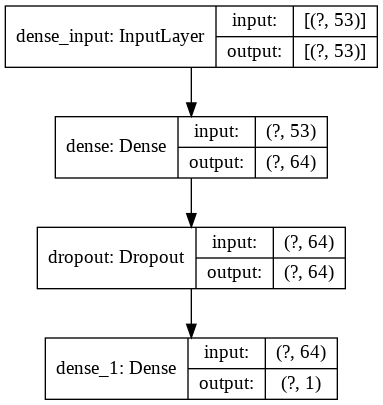

In [38]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

In [39]:
# 출력 폴더를 생성
odir = "output"
if not os.path.exists(odir):
    os.mkdir(odir)
weight_path = odir + "/weights.hdf5"

In [40]:
# hist = model.fit(X_train, y_train, epochs=1000, batch_size=X_train.shape[0])

hist = model.fit(X_train, y_train, epochs=1000, batch_size=X_train.shape[0], validation_split= 0.2,
                 callbacks=[ModelCheckpoint(monitor='val_accuracy', filepath=weight_path, verbose=1, save_best_only=True)
                            #ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_delta=1e-5)
                            #EarlyStopping(monitor='accuracy', mode='min', verbose=1, patience=100)
                            ])

#model.fit(X_train, y_train, epochs=1000, batch_size=X_train.shape[0]//10)
#model = KerasClassifier(build_fn=create_model, epochs=150, batch_size=10, verbose=0)
#kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
#results = cross_val_score(model, X_train, y_train, cv=kfold)

Epoch 1/1000
1/1 [==============================] - ETA: 0s - loss: 7.6320 - accuracy: 0.5087
Epoch 00001: val_accuracy improved from -inf to 0.46535, saving model to output/weights.hdf5
1/1 [==============================] - 1s 503ms/step - loss: 7.6320 - accuracy: 0.5087 - val_loss: 9.4524 - val_accuracy: 0.4653
Epoch 2/1000
1/1 [==============================] - ETA: 0s - loss: 9.2955 - accuracy: 0.5136
Epoch 00002: val_accuracy did not improve from 0.46535
1/1 [==============================] - 0s 17ms/step - loss: 9.2955 - accuracy: 0.5136 - val_loss: 6.6300 - val_accuracy: 0.4653
Epoch 3/1000
1/1 [==============================] - ETA: 0s - loss: 6.6676 - accuracy: 0.5136
Epoch 00003: val_accuracy improved from 0.46535 to 0.52475, saving model to output/weights.hdf5
1/1 [==============================] - 0s 34ms/step - loss: 6.6676 - accuracy: 0.5136 - val_loss: 0.6898 - val_accuracy: 0.5248
Epoch 4/1000
1/1 [==============================] - ETA: 0s - loss: 3.3019 - accuracy: 0.

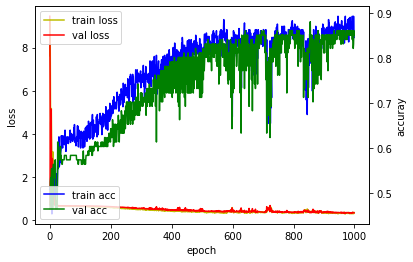

In [41]:
# 모델 학습 과정 표시하기

%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [42]:
yhat = model.predict(X_test)
for idx in range(len(yhat)):
    if yhat[idx] >= 0.5:
        yhat[idx] = 1
    else:
        yhat[idx] = 0 

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, yhat)
(confusion_matrix(y_test, yhat)[0][0] + confusion_matrix(y_test, yhat)[1][1])/(confusion_matrix(y_test, yhat)[0][0] + confusion_matrix(y_test, yhat)[0][1]+(confusion_matrix(y_test, yhat)[1][0] + confusion_matrix(y_test, yhat)[1][1]))

0.8188976377952756